# Kalman Filter
#### Description
Here we assume a Hidden Markov Model, where we observe states of an agent and use those observed states to approximate the true (hidden) states of the agent. We use the Kalman Filter algorithm to approximate true states of an agent given its hidden states.

In [0]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import skimage.feature
import seaborn

#Load data and center the mean at zero
kfdata = scipy.io.loadmat('kfdata.mat')
data = kfdata['data']
true_data = kfdata['true_data']

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

# Iterate

In [0]:
NUM_POINTS = len(data)

y = data
mus = np.zeros((NUM_POINTS, 6, 1))
sigmas = np.zeros((NUM_POINTS, 6, 6))
sigma_prime = np.dot(np.dot(A, sigma_t), A.T) + Q

for i in range(0,NUM_POINTS):
    if i == 0:
        mu_prev = mu_t
        sigma_prev = sigma_t
    else:
        mu_prev = mus[i - 1]
        sigma_prev = sigmas[i - 1]        
    st = np.dot(np.dot(C, sigma_prime),C.T) + R
    kt = np.dot(np.dot(sigma_prime, C.T), np.linalg.pinv(st))
    y_expected = np.dot(np.dot(C, A), mu_prev)
    mus[i] = np.dot(A, mu_prev) + np.dot(kt, (y[i].reshape((2,1)) - y_expected))
    sigmas[i] = np.dot((np.eye(6) - np.dot(kt, C)), sigma_prime)
    sigma_prime = np.dot(np.dot(A, sigmas[i]), A.T) + Q


# Plot

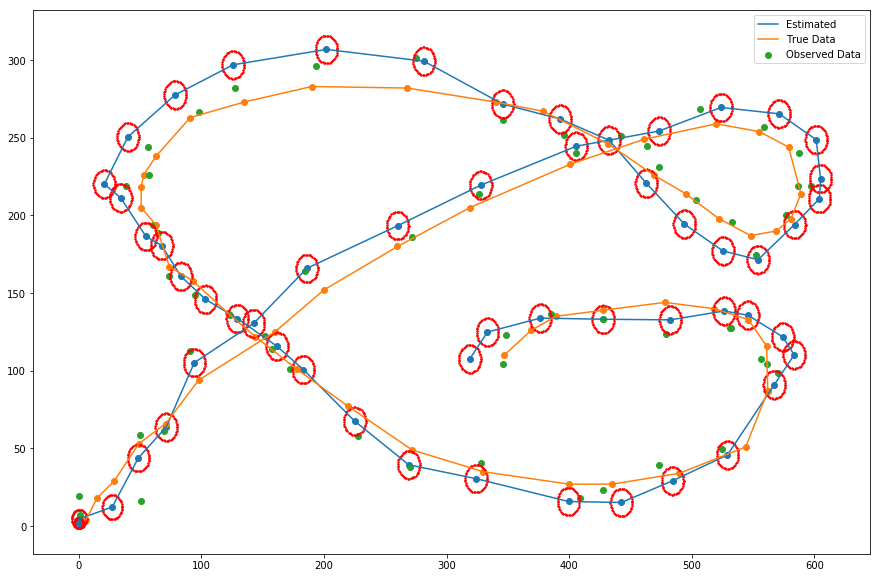

In [0]:
def cov_to_pts( cov, NUM_DOTS ):
    circ = np.linspace( 0, 2*np.pi, NUM_DOTS )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )
        
    
f, ax1 = plt.subplots(1, 1, figsize=(15,10))
#Plot estimated values and line
ax1.plot(mus[:,0], mus[:,1], label='Estimated')
ax1.scatter(mus[:,0], mus[:,1])
ax1.plot(true_data[:,0], true_data[:,1], label='True Data')
ax1.scatter(true_data[:,0], true_data[:,1])
ax1.scatter(data[:,0], data[:,1], label='Observed Data')

#Define and plot covariance ellipses
NUM_DOTS = 50
NUM_VARIABLES = 2
covariances = np.zeros((NUM_POINTS, NUM_VARIABLES, NUM_DOTS))
for i in range(NUM_POINTS):
    #Calculate covariances, modifying sigma and mu to only include the positional components
    covariances[i, :, :] = cov_to_pts(sigmas[i,0:2,0:2], NUM_DOTS) + mu[i,0:2,:]
    ax1.scatter(covariances[i,0,:], covariances[i,1,:], s=2, c='Red')

ax1.legend()
plt.show()

# Ball Tracker
We now apply a Kalman Filter to attempt to track a ball moving on a complicated background. We have noise in our indicated (observed) states, and use dynamics of kinematics to attempt to approximate the true location of the ball given noisy observations.

In [0]:
tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty

#sets there to be almost no noise in the previous state's position estimate
POS_X = .000001
POS_Y = .000001

#sets there to be little noise in the previous state's velocity
VEL_X = .001
VEL_Y = .001

#sets there to be some noise in the acceleration measured at the previous state - allows the observed to change the acceleration
ACCEL_X = 1
ACCEL_Y = 1

Q = np.asarray([
    [ POS_X, 0, 0, 0, 0, 0 ],
    [ 0, POS_Y, 0, 0, 0, 0 ],
    [ 0, 0, VEL_X, 0, 0, 0 ],
    [ 0, 0, 0, VEL_Y, 0, 0 ],
    [ 0, 0, 0, 0, ACCEL_X, 0 ],
    [ 0, 0, 0, 0, 0, ACCEL_Y ] ])
    
    
# our observation noise
R = 20000 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
data = np.asarray( data )

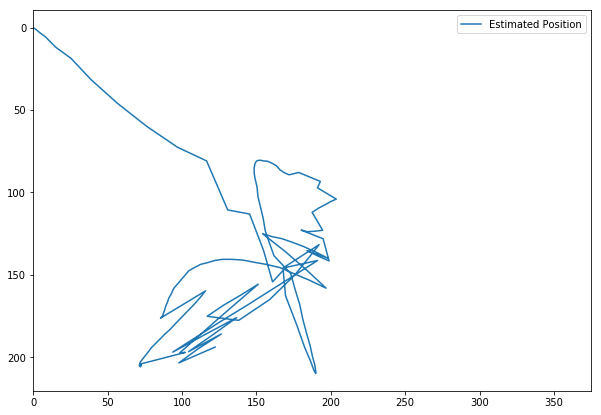

In [0]:
NUM_POINTS = len(data)

y = data
mus = np.zeros((NUM_POINTS, 6, 1))
sigmas = np.zeros((NUM_POINTS, 6, 6))
sigma_prime = np.dot(np.dot(A, sigma_t), A.T) + Q

for i in range(0,NUM_POINTS):
    if i == 0:
        mu_prev = mu_t
        sigma_prev = sigma_t
    else:
        mu_prev = mus[i - 1]
        sigma_prev = sigmas[i - 1]
    st = np.dot(np.dot(C, sigma_prime),C.T) + R
    kt = np.dot(np.dot(sigma_prime, C.T), np.linalg.pinv(st))
    y_expected = np.dot(np.dot(C, A), mu_prev)
    mus[i] = np.dot(A, mu_prev) + np.dot(kt, (y[i].reshape((2,1)) - y_expected))
    sigmas[i] = np.dot((np.eye(6) - np.dot(kt, C)), sigma_prime)
    sigma_prime = np.dot(np.dot(A, sigmas[i]), A.T) + Q
    
f, ax2 = plt.subplots(1, 1, figsize=(10,7))
#Plot estimated values and line
ax2.plot(mus[:,0], mus[:,1], label='Estimated Position')
plt.gca().invert_yaxis()
plt.xlim(0, 375)
ax2.legend()
plt.show()

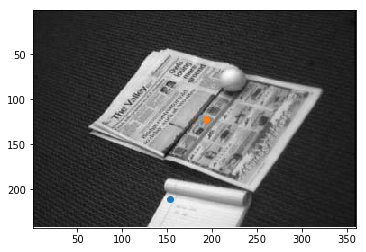

In [0]:
# assumes that "mus" contains a list of Gaussian means, and that "covs" is a list of Gaussian covariances
# also assumes you are running in Jupyter Notebook
 
from IPython.display import clear_output
 
 
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    plt.figure(1)
    plt.clf()
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( data[t][1], data[t][0] )
    plt.scatter( mus[t][1], mus[t][0] )
 
    foo = cov_to_pts( sigmas[t][0:2,0:2], 200 )
 
    plt.plot( foo[0,:] + mus[t][1], foo[1,:] + mus[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    clear_output(wait = True)
 
    plt.pause(0.001)

In [0]:
#EXPLANATION OF CHOICE FOR Q AND R

#sets there to be almost no noise in the previous state's position estimate
POS_X = .000001
POS_Y = .000001

#sets there to be little noise in the previous state's velocity
VEL_X = .001
VEL_Y = .001

#sets there to be some noise in the acceleration measured at the previous state - allows the observed to change the acceleration
ACCEL_X = 1
ACCEL_Y = 1

Q = np.asarray([
    [ POS_X, 0, 0, 0, 0, 0 ],
    [ 0, POS_Y, 0, 0, 0, 0 ],
    [ 0, 0, VEL_X, 0, 0, 0 ],
    [ 0, 0, 0, VEL_Y, 0, 0 ],
    [ 0, 0, 0, 0, ACCEL_X, 0 ],
    [ 0, 0, 0, 0, 0, ACCEL_Y ] ])
    
    
# our observation noise is very high, allowing us to trust the previous state and not be affected as much by noise in the observation
R = 20000 * np.eye( 2 )